## Imports and paths

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# import pyogg
import librosa

from tqdm.notebook import tqdm # loading bar

from IPython.display import Audio

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

from xgboost import XGBClassifier

from src.models import score


In [3]:
DATA_DIR = "../../data/raw"
TRAIN_AUDIO_DIR = os.path.join(DATA_DIR, "train_audio")
train_csv_path = os.path.join(DATA_DIR, "train_metadata.csv")

## Exploratory Data Analysis

In [4]:
train_df = pd.read_csv(train_csv_path)
train_df.head()

,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,license,rating,url,filename
0,asbfly,[],['call'],39.2297,118.1987,Muscicapa dauurica,Asian Brown Flycatcher,Matt Slaymaker,Creative Commons Attribution-NonCommercial-Sha...,5.0,https://www.xeno-canto.org/134896,asbfly/XC134896.ogg
1,asbfly,[],['song'],51.4030,104.6401,Muscicapa dauurica,Asian Brown Flycatcher,Magnus Hellström,Creative Commons Attribution-NonCommercial-Sha...,2.5,https://www.xeno-canto.org/164848,asbfly/XC164848.ogg
2,asbfly,[],['song'],36.3319,127.3555,Muscicapa dauurica,Asian Brown Flycatcher,Stuart Fisher,Creative Commons Attribution-NonCommercial-Sha...,2.5,https://www.xeno-canto.org/175797,asbfly/XC175797.ogg
3,asbfly,[],['call'],21.1697,70.6005,Muscicapa dauurica,Asian Brown Flycatcher,vir joshi,Creative Commons Attribution-NonCommercial-Sha...,4.0,https://www.xeno-canto.org/207738,asbfly/XC207738.ogg
4,asbfly,[],['call'],15.5442,73.7733,Muscicapa dauurica,Asian Brown Flycatcher,Albert Lastukhin & Sergei Karpeev,Creative Commons Attribution-NonCommercial-Sha...,4.0,https://www.xeno-canto.org/209218,asbfly/XC209218.ogg


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24459 entries, 0 to 24458
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   primary_label     24459 non-null  object 
 1   secondary_labels  24459 non-null  object 
 2   type              24459 non-null  object 
 3   latitude          24081 non-null  float64
 4   longitude         24081 non-null  float64
 5   scientific_name   24459 non-null  object 
 6   common_name       24459 non-null  object 
 7   author            24459 non-null  object 
 8   license           24459 non-null  object 
 9   rating            24459 non-null  float64
 10  url               24459 non-null  object 
 11  filename          24459 non-null  object 
dtypes: float64(3), object(9)
memory usage: 2.2+ MB


In [6]:
train_df.isnull().sum()

primary_label         0
secondary_labels      0
type                  0
latitude            378
longitude           378
scientific_name       0
common_name           0
author                0
license               0
rating                0
url                   0
filename              0
dtype: int64

In [7]:
train_df.primary_label.nunique()

182

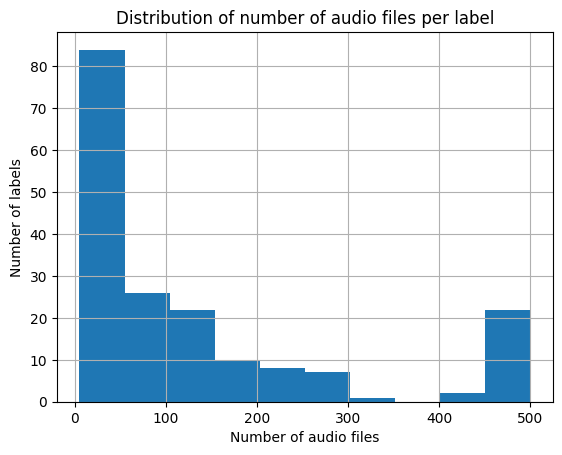

In [8]:
train_df.primary_label.value_counts().hist()
plt.title("Distribution of number of audio files per label")
plt.xlabel("Number of audio files")
plt.ylabel("Number of labels");

In [9]:
train_df.secondary_labels.value_counts()

secondary_labels
[]                                                       22567
['houspa']                                                 186
['eucdov']                                                  82
['houcro1']                                                 76
['spodov']                                                  47
                                                         ...  
['marsan']                                                   1
['indrol2']                                                  1
['blrwar1', 'pursun4']                                       1
['laudov1', 'pursun4']                                       1
['ashpri1', 'commyn', 'compea', 'labcro1', 'yebbab1']        1
Name: count, Length: 491, dtype: int64

### Audio file import

In [10]:
train_df['filepath'] = train_df.apply(lambda row: os.path.join(TRAIN_AUDIO_DIR, row['filename']), axis=1)
train_df.head()

,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,license,rating,url,filename,filepath
0,asbfly,[],['call'],39.2297,118.1987,Muscicapa dauurica,Asian Brown Flycatcher,Matt Slaymaker,Creative Commons Attribution-NonCommercial-Sha...,5.0,https://www.xeno-canto.org/134896,asbfly/XC134896.ogg,../../data/raw/train_audio/asbfly/XC134896.ogg
1,asbfly,[],['song'],51.4030,104.6401,Muscicapa dauurica,Asian Brown Flycatcher,Magnus Hellström,Creative Commons Attribution-NonCommercial-Sha...,2.5,https://www.xeno-canto.org/164848,asbfly/XC164848.ogg,../../data/raw/train_audio/asbfly/XC164848.ogg
2,asbfly,[],['song'],36.3319,127.3555,Muscicapa dauurica,Asian Brown Flycatcher,Stuart Fisher,Creative Commons Attribution-NonCommercial-Sha...,2.5,https://www.xeno-canto.org/175797,asbfly/XC175797.ogg,../../data/raw/train_audio/asbfly/XC175797.ogg
3,asbfly,[],['call'],21.1697,70.6005,Muscicapa dauurica,Asian Brown Flycatcher,vir joshi,Creative Commons Attribution-NonCommercial-Sha...,4.0,https://www.xeno-canto.org/207738,asbfly/XC207738.ogg,../../data/raw/train_audio/asbfly/XC207738.ogg
4,asbfly,[],['call'],15.5442,73.7733,Muscicapa dauurica,Asian Brown Flycatcher,Albert Lastukhin & Sergei Karpeev,Creative Commons Attribution-NonCommercial-Sha...,4.0,https://www.xeno-canto.org/209218,asbfly/XC209218.ogg,../../data/raw/train_audio/asbfly/XC209218.ogg


In [11]:
audio1 = train_df.filepath.iloc[0]
audio_data, sample_rate = librosa.load(audio1)

In [12]:
audio_data

array([ 1.1239055e-06, -3.5725856e-07, -2.4089284e-06, ...,
        4.8919164e-06, -3.7033487e-07,  0.0000000e+00], dtype=float32)

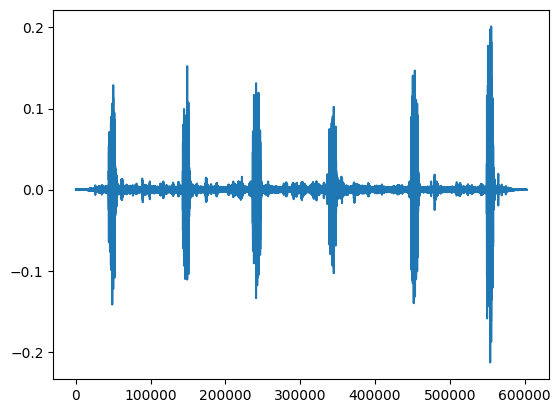

In [13]:
plt.plot(audio_data);

In [14]:
duration = librosa.get_duration(y=audio_data, sr=sample_rate)
duration

27.350249433106576

In [15]:
Audio(data=audio_data, rate=sample_rate)

## Filter out large files (for the moment)

In [16]:
train_df['filesize'] = train_df.apply(lambda row: os.path.getsize(row['filepath']), axis=1)
train_df.head()

,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,license,rating,url,filename,filepath,filesize
0,asbfly,[],['call'],39.2297,118.1987,Muscicapa dauurica,Asian Brown Flycatcher,Matt Slaymaker,Creative Commons Attribution-NonCommercial-Sha...,5.0,https://www.xeno-canto.org/134896,asbfly/XC134896.ogg,../../data/raw/train_audio/asbfly/XC134896.ogg,196771
1,asbfly,[],['song'],51.4030,104.6401,Muscicapa dauurica,Asian Brown Flycatcher,Magnus Hellström,Creative Commons Attribution-NonCommercial-Sha...,2.5,https://www.xeno-canto.org/164848,asbfly/XC164848.ogg,../../data/raw/train_audio/asbfly/XC164848.ogg,125336
2,asbfly,[],['song'],36.3319,127.3555,Muscicapa dauurica,Asian Brown Flycatcher,Stuart Fisher,Creative Commons Attribution-NonCommercial-Sha...,2.5,https://www.xeno-canto.org/175797,asbfly/XC175797.ogg,../../data/raw/train_audio/asbfly/XC175797.ogg,206323
3,asbfly,[],['call'],21.1697,70.6005,Muscicapa dauurica,Asian Brown Flycatcher,vir joshi,Creative Commons Attribution-NonCommercial-Sha...,4.0,https://www.xeno-canto.org/207738,asbfly/XC207738.ogg,../../data/raw/train_audio/asbfly/XC207738.ogg,110256
4,asbfly,[],['call'],15.5442,73.7733,Muscicapa dauurica,Asian Brown Flycatcher,Albert Lastukhin & Sergei Karpeev,Creative Commons Attribution-NonCommercial-Sha...,4.0,https://www.xeno-canto.org/209218,asbfly/XC209218.ogg,../../data/raw/train_audio/asbfly/XC209218.ogg,376492


In [17]:
train_df.filesize.describe()

count    2.445900e+04
mean     3.194286e+05
std      7.927288e+05
min      7.235000e+03
25%      8.839900e+04
50%      1.722410e+05
75%      3.400315e+05
max      4.670163e+07
Name: filesize, dtype: float64

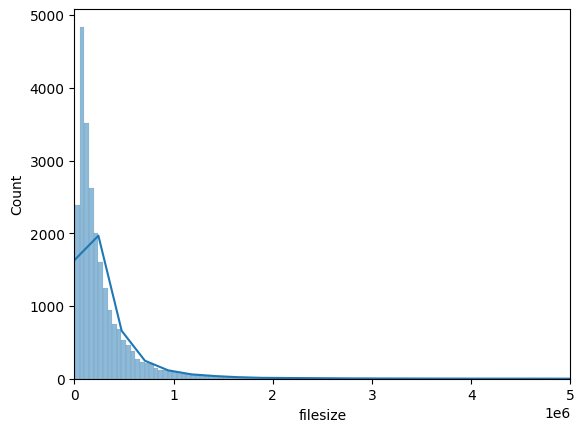

In [18]:
sns.histplot(train_df.filesize, bins=1000, kde=True)
plt.xlim(0, 0.5e7);

In [19]:
train_df = train_df[train_df['filesize'] < 1e6]

## Train test split

In [20]:
random_state = 43

# Define the number of classes to keep
num_classes_to_keep = 100

# Define the fraction of data to keep for classes with more labels
fraction_to_keep = 0.05

# Calculate the minimum number of instances to keep for classes with fewer labels
min_count = 50

# Calculate weights to balance the classes
class_weights = train_df['primary_label'].value_counts()

# Select the top classes to keep based on their frequencies
top_classes = class_weights.head(num_classes_to_keep).index.tolist()

# Initialize an empty DataFrame to store the sampled subset
train_subset_df = pd.DataFrame()

# Iterate over each class
for label, count in class_weights.items():
    # Check if the class is in the top classes to keep
    if label in top_classes:
        # Check if the class has fewer labels than the minimum count
        if count < min_count:
            # Keep all instances for classes with fewer labels
            subset = train_df[train_df['primary_label'] == label]
        else:
            # Randomly sample a fraction for classes with more labels
            fraction = min(fraction_to_keep, min_count / count)  # Adjust fraction if necessary
            subset = train_df[train_df['primary_label'] == label].sample(frac=fraction, random_state=random_state)
        # Append the subset to the final DataFrame
        train_subset_df = pd.concat([train_subset_df, subset])

# Shuffle the final DataFrame to mix the classes
train_subset_df = train_subset_df.sample(frac=1, random_state=random_state).reset_index(drop=True)


In [21]:
train_subset_df.primary_label.value_counts()

primary_label
emedov2    49
zitcis1    25
commoo3    25
comsan     25
grnsan     25
           ..
gryfra      3
whcbar1     3
btbeat1     3
insbab1     3
inbrob1     3
Name: count, Length: 100, dtype: int64

In [22]:
# Train val split
train_train_df, val_df = train_test_split(train_subset_df, test_size=0.3, stratify = train_subset_df.primary_label, random_state=random_state) 
X_train_files = train_train_df.filepath
X_val_files = val_df.filepath

y_train = train_train_df.primary_label
y_val = val_df.primary_label


In [23]:
y_train.value_counts()

primary_label
emedov2    34
comkin1    17
barswa     17
bkwsti     17
grnsan     17
           ..
grbeat1     2
whbbul2     2
whrmun      2
gryfra      2
whcbar1     2
Name: count, Length: 100, dtype: int64

In [24]:
y_val.value_counts()

primary_label
emedov2    15
grnsan      8
zitcis1     8
comsan      8
commoo3     8
           ..
brwowl1     1
oripip1     1
whrmun      1
revbul      1
brcful1     1
Name: count, Length: 100, dtype: int64

## Feature extraction

**MFCC (Mel-Frequency Cepstral Coefficients)**

MFCCs are a feature widely used in audio and speech processing. They represent the short-term power spectrum of a sound. The process to calculate MFCCs involves several steps:

- Frame the Signal: The audio signal is divided into short overlapping frames.
- Apply Windowing: Each frame is windowed, typically with a Hamming window, to minimize spectral leakage.
- Calculate the Discrete Fourier Transform (DFT): The Fast Fourier Transform (FFT) is applied to each windowed frame to convert the audio signal from the time domain to the frequency domain.
- Mel Filtering: Mel filtering is applied to the power spectrum to convert the linear frequency scale to the mel scale, which approximates the human auditory system's response to different frequencies.
- Take the Logarithm: The logarithm of the mel-filterbank energies is taken to mimic the human perception of sound intensity.
- Apply Discrete Cosine Transform (DCT): Finally, the Discrete Cosine Transform is applied to the mel-log spectrum to decorrelate the features and obtain the MFCCs.
- MFCCs capture important spectral characteristics of the audio signal and are commonly used as features for tasks like speech recognition, music genre classification, and audio classification.

**Chroma Features**

Chroma features represent the distribution of energy in different pitch classes (i.e., musical notes) within an audio signal. Chroma features are particularly useful for tasks involving music analysis and classification, such as genre classification, chord recognition, and instrument recognition.

The process to compute chroma features involves the following steps:

- Frame the Signal: Similar to MFCCs, the audio signal is divided into short overlapping frames.
- Apply Windowing: Each frame is windowed.
- Calculate the Short-Time Fourier Transform (STFT): The STFT is applied to each windowed frame to obtain the magnitude spectrum.
- Map Frequencies to Chroma: The frequency spectrum is mapped onto the 12 chroma bands corresponding to the 12 pitch classes (C, C#, D, D#, E, F, F#, G, G#, A, A#, B).
- Sum Across Octaves: Chroma features are usually computed by summing the energy within each chroma band across octaves.

Chroma features are robust to changes in pitch and timbre and are commonly used in music information retrieval tasks.

**Mel Spectrogram**

A Mel spectrogram is a spectrogram where the frequencies are converted to the mel scale, similar to the mel filtering step in MFCC computation. It represents the distribution of energy in different frequency bands over time. Mel spectrograms are often used as features for audio classification tasks.

These features capture different aspects of the audio signal's spectral content and are useful for various audio analysis and classification tasks.

In [25]:
def extract_features(filepath, mfcc=True, chroma=True, mel=True):
    audio_data, sample_rate = librosa.load(filepath)
    # audio_data, sample_rate = sf.read(filepath)

    result = np.array([])
    if mfcc: # Mel-Frequency Cepstral Coefficients
        mfccs = np.mean(librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=40).T, axis=0)
        result = np.hstack((result, mfccs))
    if chroma:
        chroma = np.mean(librosa.feature.chroma_stft(y=audio_data, sr=sample_rate).T,axis=0)
        result = np.hstack((result, chroma))
    if mel:
        mel = np.mean(librosa.feature.melspectrogram(y=audio_data, sr=sample_rate).T,axis=0)
        result = np.hstack((result, mel))
    
    return result

In [26]:
def extract_features_filepaths(X_files):
    features = []

    # Wrap the loop with tqdm to add a progress bar
    for filepath in tqdm(X_files, desc='Processing files', total=len(X_files)):

        # Extract features
        audio_features = extract_features(filepath)

        # Append features and label
        features.append(audio_features)

    X = np.array(features)
    
    return X
    

In [27]:
X_train = extract_features_filepaths(X_train_files)

Processing files:   0%|          | 0/786 [00:00<?, ?it/s]

/home/bfrisque/.pyenv/versions/3.10.6/envs/birdclef2024-lewagon-1601/lib/python3.10/site-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


In [28]:
X_val = extract_features_filepaths(X_val_files)

Processing files:   0%|          | 0/338 [00:00<?, ?it/s]

In [29]:
X_train.shape

(786, 180)

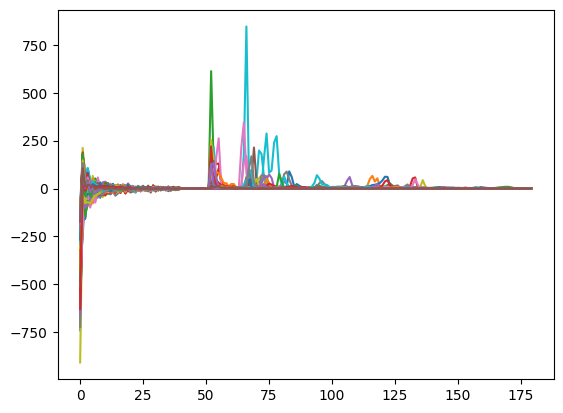

In [30]:
plt.plot(X_train.T);

## Model

### Label encoding

In [31]:
label_encoder = LabelEncoder()

y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

### Baseline: RandomForest

In [32]:
# Train a classifier
classifier = RandomForestClassifier(n_estimators=100, random_state=42)
classifier.fit(X_train, y_train_encoded)


RandomForestClassifier(random_state=42)

In [33]:
# Predict
y_pred_encoded = classifier.predict(X_val)

# Evaluate
accuracy = accuracy_score(y_val_encoded, y_pred_encoded)
print(f"Accuracy: {accuracy:.1%}")

Accuracy: 16.3%


#### Grid search


In [34]:
# Define the parameter grid for tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create a random forest classifier
classifier = RandomForestClassifier(random_state=42)

# Perform grid search cross-validation
grid_search = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search.fit(X_train, y_train_encoded)

# Get the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)

# Train the classifier with the best parameters
best_classifier = RandomForestClassifier(**best_params, random_state=42)
best_classifier.fit(X_train, y_train_encoded)

/home/bfrisque/.pyenv/versions/3.10.6/envs/birdclef2024-lewagon-1601/lib/python3.10/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


Best Parameters: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}
Best Score: 0.1895674300254453


RandomForestClassifier(max_depth=20, min_samples_leaf=2, n_estimators=300,
                       random_state=42)

In [241]:
# Define the parameter grid for tuning
param_dist= {
    'n_estimators': stats.randint(250, 400),
    'max_depth': stats.randint(15, 30),
    'min_samples_leaf': [1, 2, 4]
}

# Create a random forest classifier
classifier = RandomForestClassifier(random_state=42)

# Perform grid search cross-validation
random_search = RandomizedSearchCV(estimator=classifier, param_distributions=param_dist, cv=3, n_jobs=-1, verbose=2)
random_search.fit(X_train, y_train_encoded)

# Get the best parameters and the best score
best_params = random_search.best_params_
best_score = random_search.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/home/bfrisque/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


Best Parameters: {'max_depth': 23, 'min_samples_leaf': 1, 'n_estimators': 380}
Best Score: 0.18447837150127225


In [35]:
# Train the classifier with the best parameters
best_classifier = RandomForestClassifier(max_depth=20, min_samples_leaf=2, n_estimators=300, random_state=42)
best_classifier.fit(X_train, y_train_encoded)

RandomForestClassifier(max_depth=20, min_samples_leaf=2, n_estimators=300,
                       random_state=42)

In [36]:
# Predict
y_pred_encoded = best_classifier.predict(X_val)

# # Evaluate
accuracy = accuracy_score(y_val_encoded, y_pred_encoded)
print(f"Accuracy: {accuracy:.1%}")

Accuracy: 18.0%


### XGBoost

In [214]:
xg_train = xgb.DMatrix(X_train, label=y_train_encoded)
xg_val = xgb.DMatrix(X_val, label=y_val_encoded)

# setup parameters for xgboost
param = {}
# use softmax multi-class classification
param['objective'] = 'multi:softmax'
# scale weight of positive examples
param['eta'] = 0.1
param['max_depth'] = 10
param['nthread'] = 4
param['num_class'] = y_train.nunique()


# Specify which dataset and which metric should be used for early stopping.
early_stop = xgb.callback.EarlyStopping(rounds=5,
                                        save_best=True,
                                        data_name='validation')

watchlist = [(xg_train, 'train'), (xg_val, 'validation')]

xgb_classifier = xgb.train(param, xg_train, num_boost_round=500, evals=watchlist, callbacks=[early_stop])


[0]	train-mlogloss:4.32857	validation-mlogloss:4.50043
[1]	train-mlogloss:4.07307	validation-mlogloss:4.42600
[2]	train-mlogloss:3.82501	validation-mlogloss:4.36657
[3]	train-mlogloss:3.60440	validation-mlogloss:4.32543
[4]	train-mlogloss:3.38720	validation-mlogloss:4.29525
[5]	train-mlogloss:3.18605	validation-mlogloss:4.26659
[6]	train-mlogloss:3.00088	validation-mlogloss:4.24477
[7]	train-mlogloss:2.82437	validation-mlogloss:4.22647
[8]	train-mlogloss:2.66095	validation-mlogloss:4.21169
[9]	train-mlogloss:2.50404	validation-mlogloss:4.19800
[10]	train-mlogloss:2.36134	validation-mlogloss:4.18865
[11]	train-mlogloss:2.22411	validation-mlogloss:4.18142
[12]	train-mlogloss:2.09624	validation-mlogloss:4.17259
[13]	train-mlogloss:1.97634	validation-mlogloss:4.16442
[14]	train-mlogloss:1.86594	validation-mlogloss:4.15157
[15]	train-mlogloss:1.76169	validation-mlogloss:4.13602
[16]	train-mlogloss:1.66335	validation-mlogloss:4.12949
[17]	train-mlogloss:1.57230	validation-mlogloss:4.12445
[1

In [215]:
y_val_pred_encoded = xgb_classifier.predict(dval).astype(np.int32)

# Decode the predicted labels
y_val_pred = label_encoder.inverse_transform(y_val_pred_encoded)

# Evaluate
accuracy = accuracy_score(y_val, y_val_pred)
print(f"Accuracy: {accuracy:.1%}")

Accuracy: 13.6%
